In [56]:
using PyPlot
using JuMP, Ipopt

In [57]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");

## Model setup

#### Physical parameters

In [58]:
# Model domain
dt = 1.
t = Array(2020:dt:2200);

# "Best-guess equilibrium climate sensitivity"
ECS = 3.0;

#### Economic parameters

Assume damages of 2% of global world product (GWP) for 3$^{\circ}$C of warming (similar to DICE damage function).

In [59]:
GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.025 # ρ (relative low value from Stern review)

# Control technology cost scales (for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.02*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

In [60]:
baseline_emissions_scenario = baseline_emissions(t, 5., 2060., 40.)

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0., # Assumed initial condition of no deployments in 2020
    baseline_emissions_scenario
);

### Initialize model

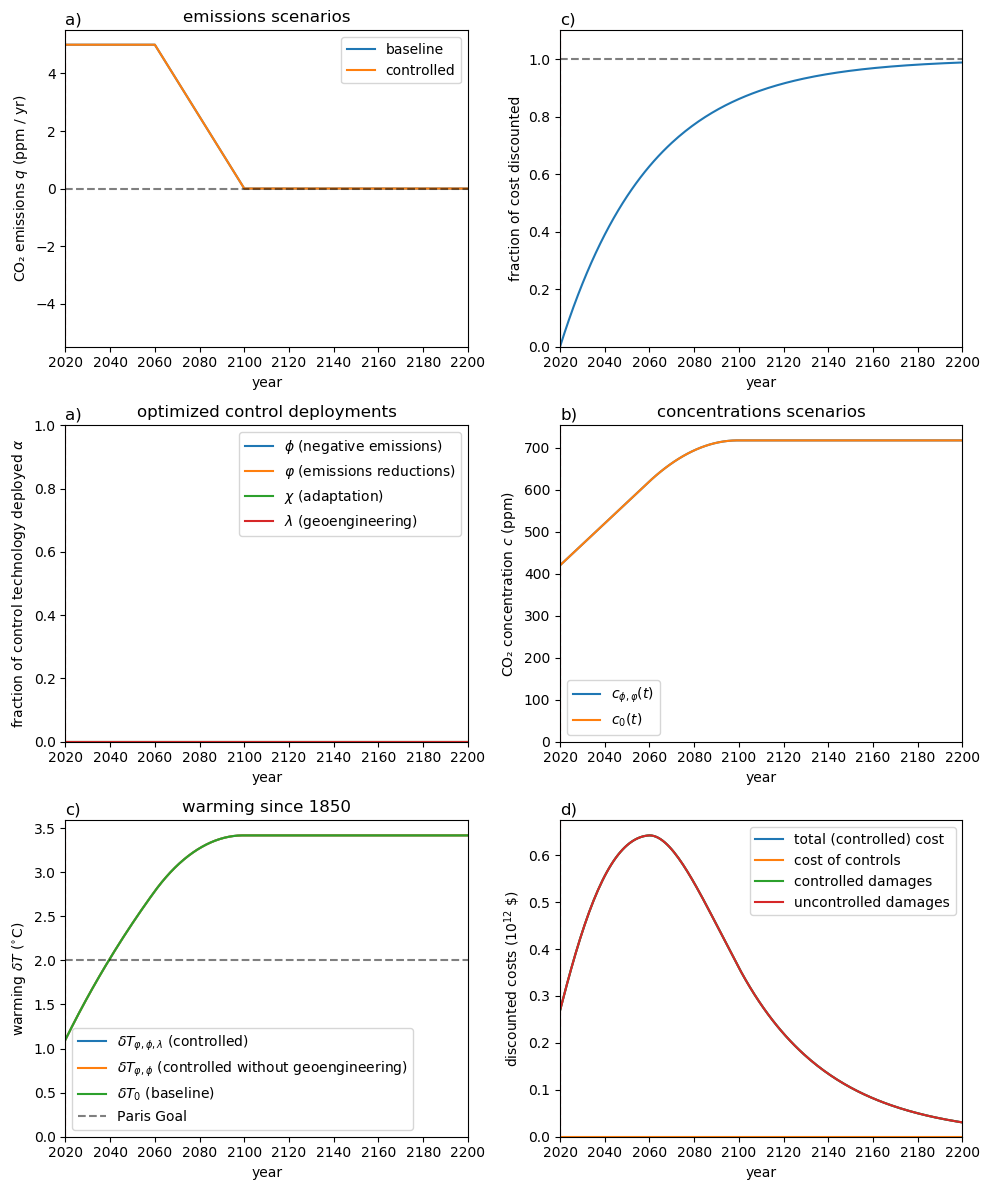

Social cost of carbon: $24.99.

In [61]:
ensemble = Dict{String, ClimateModel}();

name = "Example configuration";
present_year = 2020.

# Arbitrary initial guess of climate control policies,
# to be optimized later!
controls = init_zero_controls(t);

# Create instance of idealized integrated assessment climate model
model = ClimateModel(name, ECS, t, dt, controls, economics, present_year);

# Plot initial state (baseline scenario; zero controls)
plot_state(model)

print(string(
        "Social cost of carbon: \$",
        SCC(model),"."))

# Model optimization

## Constraint on total discounted control budget

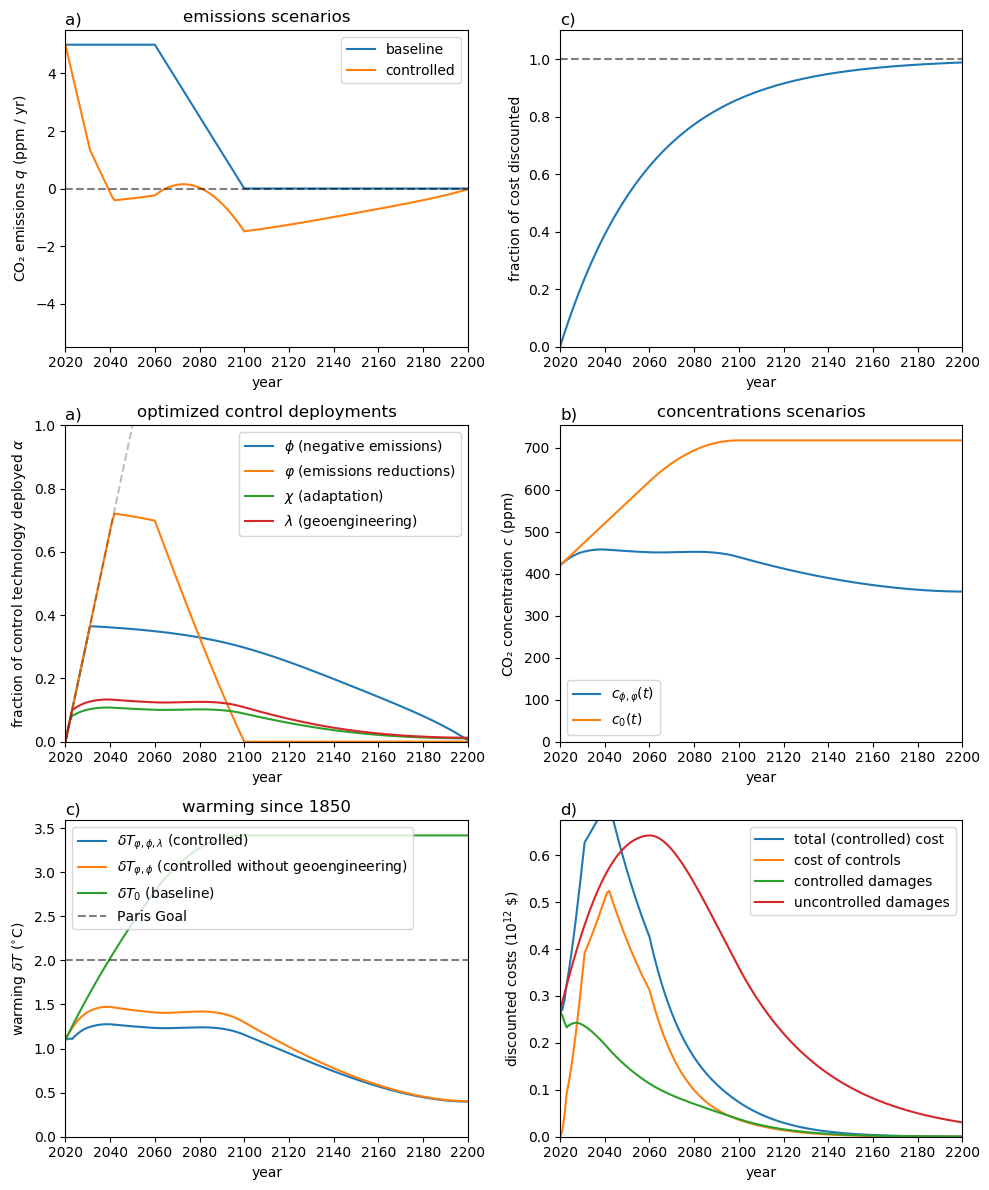

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2776
Number of nonzeros in inequality constraint Jacobian.:      720
Number of nonzeros in Lagrangian Hessian.............:     2341

Total number of variables............................:     1621
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1440
                     variables with only upper bounds:        0
Total number of equality constraints.................:      901
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d58d860>

In [62]:
maxslope = 1. /30.
optimize_controls!(model, maxslope = maxslope, obj_option = "budget", budget=20.);
plot_state(model)
subplot(3,2,3)
plot([2020., 2020. + 1. /maxslope], [0.,1.], "k--", alpha=0.25)

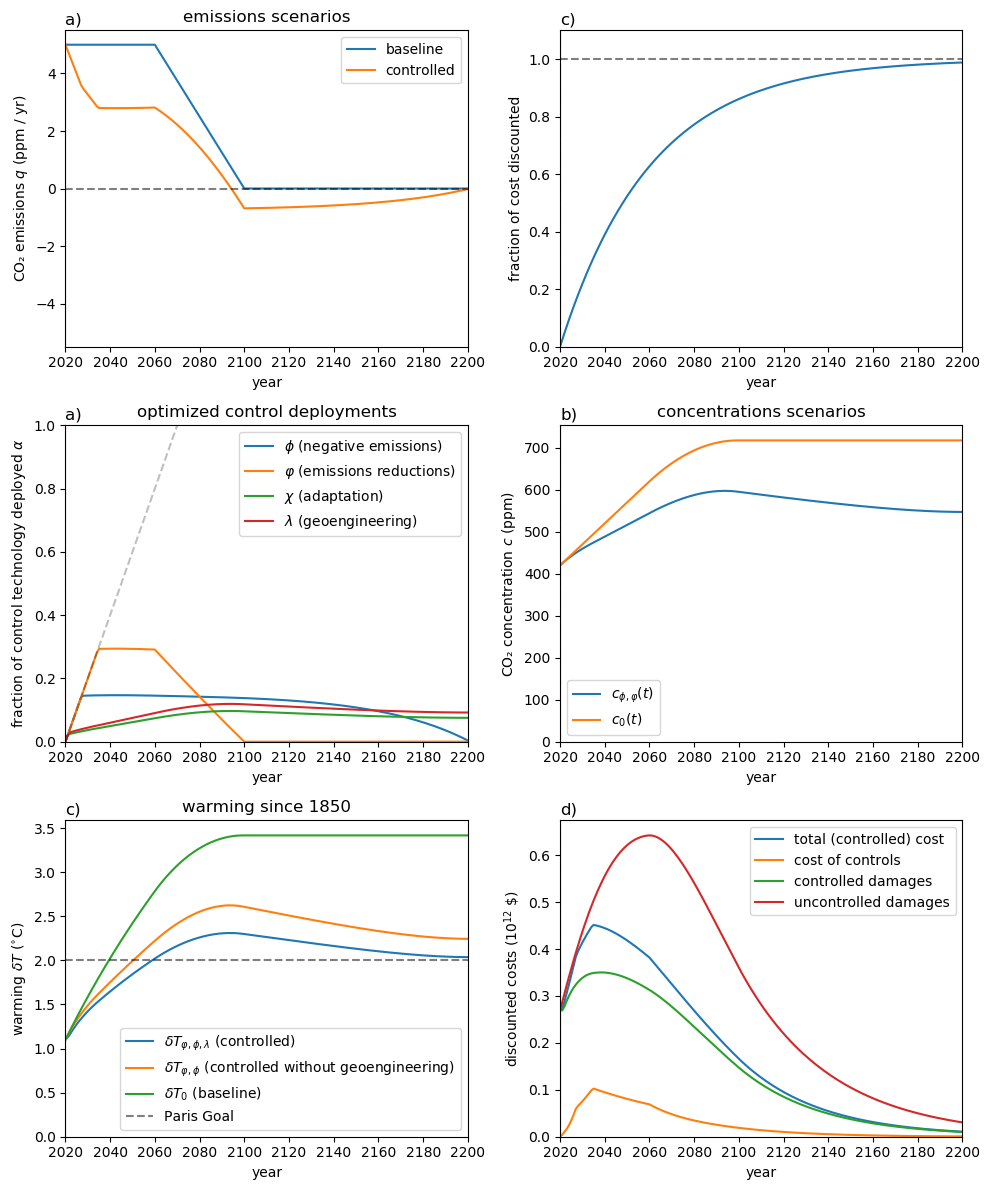

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2776
Number of nonzeros in inequality constraint Jacobian.:      720
Number of nonzeros in Lagrangian Hessian.............:     2341

Total number of variables............................:     1621
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1440
                     variables with only upper bounds:        0
Total number of equality constraints.................:      901
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14bf5eb38>

In [63]:
maxslope = 1. /50.
optimize_controls!(model, maxslope = maxslope, obj_option = "budget", budget=5.);
plot_state(model)
subplot(3,2,3)
plot([2020., 2020. + 1. /maxslope], [0.,1.], "k--", alpha=0.25)

## Annual expenditures constraint

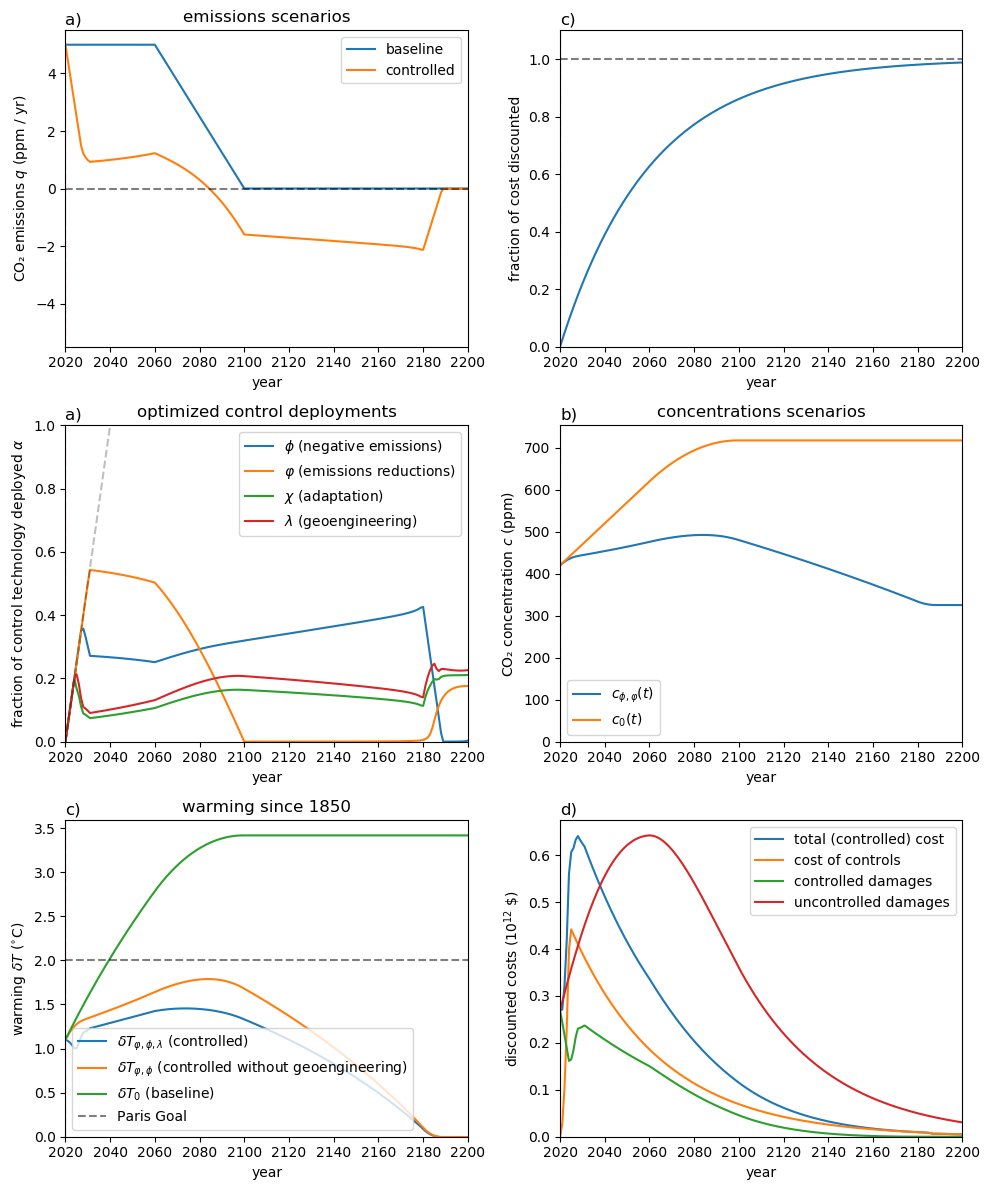

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2776
Number of nonzeros in inequality constraint Jacobian.:      720
Number of nonzeros in Lagrangian Hessian.............:     2341

Total number of variables............................:     1621
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1440
                     variables with only upper bounds:        0
Total number of equality constraints.................:      901
Total number of inequality constraints...............:      181
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      181

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x148348470>

In [64]:
maxslope = 1. /20.
optimize_controls!(model, maxslope = maxslope, obj_option = "expenditure", expenditure=0.5);
plot_state(model)
subplot(3,2,3)
plot([2020., 2020. + 1. /maxslope], [0.,1.], "k--", alpha=0.25)